# PINN  modello mRNA-Proteina 



In [11]:

import copy, math, random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.init import xavier_uniform_


# -----------------------
# Reproducibility + device
# -----------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [12]:
torch.set_default_dtype(torch.float32)

In [13]:
use_nonlinear_variant = False  # keep linear variant by default

# ground truth parameters (used to create synthetic data)
PN_true = 50.0
km_true = 0.6
kp_true = 0.9
gamma_m_true = 0.4
gamma_p_true = 0.5

M0_true = 1.0
P0_true = 1.0

T_final = 50.0
n_time = 400

def rhs_linear(M, P, params):
    km, kp, gm, gp, PN = params
    dM = km * PN - gm * M
    dP = kp * M - gp * P
    return dM, dP

def rhs_nonlinear_literal(M, P, params):
    km, kp, gm, gp, PN = params
    dM = km * PN * (M**2) - gm * M
    dP = kp * M * (P**2) - gp * P
    return dM, dP

rhs = rhs_nonlinear_literal if use_nonlinear_variant else rhs_linear

# -----------------------
# RK4 simulation for synthetic data
# -----------------------
def rk4_step(M, P, dt, params):
    f = rhs
    k1_M, k1_P = f(M, P, params)
    k2_M, k2_P = f(M + 0.5*dt*k1_M, P + 0.5*dt*k1_P, params)
    k3_M, k3_P = f(M + 0.5*dt*k2_M, P + 0.5*dt*k2_P, params)
    k4_M, k4_P = f(M + dt*k3_M, P + dt*k3_P, params)
    M_next = M + (dt/6.0)*(k1_M + 2*k2_M + 2*k3_M + k4_M)
    P_next = P + (dt/6.0)*(k1_P + 2*k2_P + 2*k3_P + k4_P)
    return M_next, P_next

def simulate(params, M0, P0, t_grid):
    M = np.zeros_like(t_grid)
    P = np.zeros_like(t_grid)
    M[0] = M0
    P[0] = P0
    for i in range(len(t_grid)-1):
        dt = t_grid[i+1] - t_grid[i]
        M[i+1], P[i+1] = rk4_step(M[i], P[i], dt, params)
    return M, P

t_grid = np.linspace(0.0, T_final, n_time)
params_true = (km_true, kp_true, gamma_m_true, gamma_p_true, PN_true)
M_true, P_true = simulate(params_true, M0_true, P0_true, t_grid)

# Observations: sparse + noisy
obs_fraction = 0.25
idx_obs = np.sort(np.random.choice(n_time, size=int(n_time*obs_fraction), replace=False))
noise_std_M = 0.02
noise_std_P = 0.02
M_obs = M_true[idx_obs] + noise_std_M * np.random.randn(len(idx_obs))
P_obs = P_true[idx_obs] + noise_std_P * np.random.randn(len(idx_obs))
t_obs = t_grid[idx_obs]

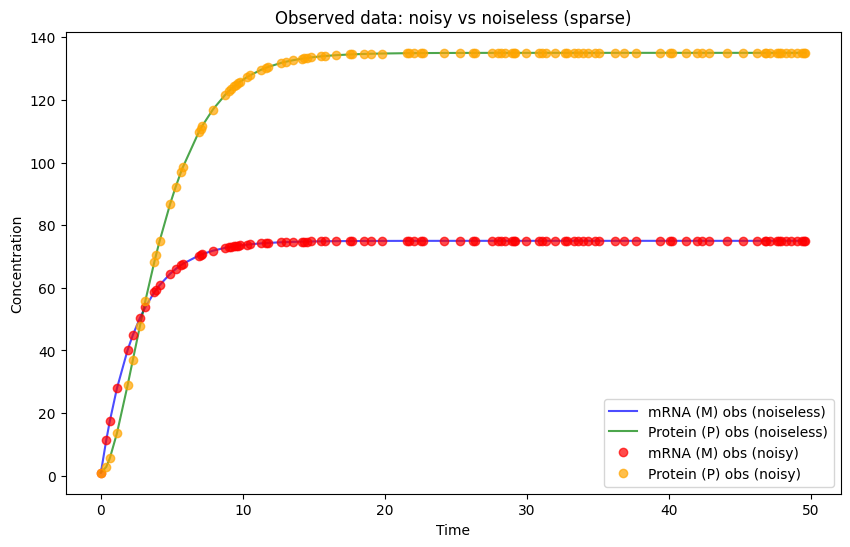

In [14]:
# Plot sparse data: both noisy and noiseless, for M and P together

# Sparse noiseless data
M_obs_noiseless = M_true[idx_obs]
P_obs_noiseless = P_true[idx_obs]

plt.figure(figsize=(10,6))

# Noiseless points
plt.plot(t_obs, M_obs_noiseless, label="mRNA (M) obs (noiseless)", color="blue", alpha=0.7)
plt.plot(t_obs, P_obs_noiseless, label="Protein (P) obs (noiseless)", color="green", alpha=0.7)

# Noisy points
plt.plot(t_obs, M_obs, 'o', label="mRNA (M) obs (noisy)", color="red", alpha=0.7)
plt.plot(t_obs, P_obs, 'o', label="Protein (P) obs (noisy)", color="orange", alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("Observed data: noisy vs noiseless (sparse)")
plt.legend()
plt.show()


In [15]:
# -----------------------
# TRAIN/VAL/TEST split on observed indices
# -----------------------
# We'll split the observed points into train/val/test (e.g. 60/20/20)
idx_train_rel, idx_temp_rel = train_test_split(np.arange(len(idx_obs)), test_size=0.4, random_state=SEED)
idx_val_rel, idx_test_rel = train_test_split(idx_temp_rel, test_size=0.5, random_state=SEED)

t_train = t_obs[idx_train_rel]
M_train = M_obs[idx_train_rel]
P_train = P_obs[idx_train_rel]

t_val = t_obs[idx_val_rel]
M_val = M_obs[idx_val_rel]
P_val = P_obs[idx_val_rel]

t_test = t_obs[idx_test_rel]
M_test = M_obs[idx_test_rel]
P_test = P_obs[idx_test_rel]

print(f"Observed points: {len(idx_obs)} -> train {len(t_train)} val {len(t_val)} test {len(t_test)}")


Observed points: 100 -> train 60 val 20 test 20


In [16]:
# Full collocation (for physics): use dense grid of normalized times
t_min, t_max = t_grid.min(), t_grid.max()
t_norm = (t_grid - t_min) / (t_max - t_min)
time_scale = float(t_max - t_min)

# Tensors
def to_tensor(x, requires_grad=False):
    return torch.tensor(x.reshape(-1,1), dtype=torch.float32, device=device, requires_grad=requires_grad)

t_train_torch = to_tensor((t_train - t_min) / (t_max - t_min), requires_grad=True)
M_train_torch = to_tensor(M_train)
P_train_torch = to_tensor(P_train)

t_val_torch = to_tensor((t_val - t_min) / (t_max - t_min), requires_grad=True)
M_val_torch = to_tensor(M_val)
P_val_torch = to_tensor(P_val)

t_test_torch = to_tensor((t_test - t_min) / (t_max - t_min), requires_grad=True)
M_test_torch = to_tensor(M_test)
P_test_torch = to_tensor(P_test)

t_all_torch = to_tensor(t_norm)  # collocation all times

t0 = torch.tensor([[0.0]], dtype=torch.float32, device=device)
M0_torch = torch.tensor([[float(M0_true)]], dtype=torch.float32, device=device)
P0_torch = torch.tensor([[float(P0_true)]], dtype=torch.float32, device=device)


t_train_torch = t_train_torch.float()
M_train_torch = M_train_torch.float()
P_train_torch = P_train_torch.float()

t_val_torch = t_val_torch.float()
M_val_torch = M_val_torch.float()
P_val_torch = P_val_torch.float()

t_all_torch = t_all_torch.float()


In [17]:
# -----------------------
# MLP and PINN classes
# -----------------------
class MLP(nn.Module):
    def __init__(self, input_dim=1, out_dim=2, hidden_layers=[128,128], act=nn.GELU):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(in_dim, h))
            layers.append(act())
            in_dim = h
        layers.append(nn.Linear(in_dim, out_dim))
        self.net = nn.Sequential(*layers)

        # Xavier init
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, t):
        return self.net(t)
    
class GenePINNBase(nn.Module):
    def __init__(self, hidden_layers=[128,128], learn_params=False):
        super().__init__()
        self.net = MLP(input_dim=1, out_dim=2, hidden_layers=hidden_layers, act=nn.GELU)
        self.learn_params = learn_params
        if learn_params:
            # raw parameters will be mapped to positive via softplus
            self._raw_km = nn.Parameter(torch.tensor(0.5, dtype=torch.float32))
            self._raw_kp = nn.Parameter(torch.tensor(0.5, dtype=torch.float32))
            self._raw_gm = nn.Parameter(torch.tensor(0.5, dtype=torch.float32))
            self._raw_gp = nn.Parameter(torch.tensor(0.5, dtype=torch.float32))
            self._raw_PN = nn.Parameter(torch.tensor(10.0, dtype=torch.float32))
            self.softplus = nn.Softplus(beta=5.0)
        else:
            # fixed as buffers (so move to device with model)
            self.register_buffer('km_fixed', torch.tensor(km_true, dtype=torch.float32))
            self.register_buffer('kp_fixed', torch.tensor(kp_true, dtype=torch.float32))
            self.register_buffer('gm_fixed', torch.tensor(gamma_m_true, dtype=torch.float32))
            self.register_buffer('gp_fixed', torch.tensor(gamma_p_true, dtype=torch.float32))
            self.register_buffer('PN_fixed', torch.tensor(PN_true, dtype=torch.float32))

    def params_phys(self):
        if self.learn_params:
            km = self.softplus(self._raw_km)
            kp = self.softplus(self._raw_kp)
            gm = self.softplus(self._raw_gm)
            gp = self.softplus(self._raw_gp)
            PN = self.softplus(self._raw_PN)
        else:
            km = self.km_fixed; kp = self.kp_fixed
            gm = self.gm_fixed; gp = self.gp_fixed
            PN = self.PN_fixed
        return km, kp, gm, gp, PN

    def forward(self, t_norm):
        # t_norm in [0,1], shape (N,1)
        out = self.net(t_norm)
        M = out[:, :1]
        P = out[:, 1:2]
        # enforce positivity for concentrations
        M = torch.nn.functional.softplus(M, beta=10.0)
        P = torch.nn.functional.softplus(P, beta=10.0)
        return M, P

    def residuals(self, t_norm, time_scale):
        # Need gradients w.r.t t_norm
        t = t_norm.clone().detach().requires_grad_(True)
        M, P = self.forward(t)
        dMdt = torch.autograd.grad(M, t, grad_outputs=torch.ones_like(M), create_graph=True)[0]
        dPdt = torch.autograd.grad(P, t, grad_outputs=torch.ones_like(P), create_graph=True)[0]
        # convert to physical time
        dMdt = dMdt / time_scale
        dPdt = dPdt / time_scale

        km, kp, gm, gp, PN = self.params_phys()
        if use_nonlinear_variant:
            fM = km*PN*(M**2) - gm*M
            fP = kp*M*(P**2) - gp*P
        else:
            fM = km*PN - gm*M
            fP = kp*M - gp*P
        resM = dMdt - fM
        resP = dPdt - fP
        return resM, resP


In [18]:
# -----------------------
# Training utilities
# -----------------------
mse = nn.MSELoss()
def train_pinn(pinn, optim, t_train_torch, M_train_torch, P_train_torch,
               t_val_torch, M_val_torch, P_val_torch,
               t_test_torch, M_test_torch, P_test_torch,
               t_all_torch, time_scale,
               lambda_data=0.3, lambda_phys=0.7, lambda_ic=1.0,
               max_epochs=4000, print_every=500, snapshot_every=1000):
    history = {"loss_train": [], "loss_val": [], "loss_test": [],
               "loss_data_train": [], "loss_phys_train": [],
               "loss_data_val": [], "loss_phys_val": [],
               "loss_data_test": [], "loss_phys_test": [],
               "km": [], "kp": [], "gm": [], "gp": [], "PN": [],
               "snapshots": []}  # snapshots: list of dicts {epoch, M_pred, P_pred}
    best_val = 1e12
    best_state = None

    for epoch in range(1, max_epochs+1):
        pinn.train()
        optim.zero_grad()

        # ---- data loss (train)
        M_pred_train, P_pred_train = pinn(t_train_torch)
        loss_data_m = mse(M_pred_train, M_train_torch)
        loss_data_p = mse(P_pred_train, P_train_torch)
        loss_data = loss_data_m + loss_data_p

        # ---- physics residual on collocation points (all)
        resM_all, resP_all = pinn.residuals(t_all_torch, time_scale)
        loss_phys = mse(resM_all, torch.zeros_like(resM_all)) + mse(resP_all, torch.zeros_like(resP_all))

        # ---- IC loss
        M0_pred, P0_pred = pinn(t0)
        loss_ic = mse(M0_pred, M0_torch) + mse(P0_pred, P0_torch)

        loss = lambda_data*loss_data + lambda_phys*loss_phys + lambda_ic*loss_ic
        loss.backward()
        torch.nn.utils.clip_grad_norm_(pinn.parameters(), max_norm=10.0)
        optim.step()

        # ---- Eval train/val/test (use enable_grad when residuals need grad)
        pinn.eval()
        with torch.enable_grad():
            # validation
            M_pred_val, P_pred_val = pinn(t_val_torch)
            loss_data_val = mse(M_pred_val, M_val_torch) + mse(P_pred_val, P_val_torch)
            resM_val, resP_val = pinn.residuals(t_all_torch, time_scale)
            loss_phys_val = mse(resM_val, torch.zeros_like(resM_val)) + mse(resP_val, torch.zeros_like(resP_val))
            loss_val = lambda_data*loss_data_val + lambda_phys*loss_phys_val + lambda_ic*loss_ic  # ic same

            # test (only for logging, not for optimization)
            M_pred_test, P_pred_test = pinn(t_test_torch)
            loss_data_test = mse(M_pred_test, M_test_torch) + mse(P_pred_test, P_test_torch)
            # for phys test we can reuse residuals on collocation (resM_all) as proxy
            loss_phys_test = loss_phys_val  # cheap choice; or compute residuals on a separate collocation for test if desired
            loss_test = lambda_data*loss_data_test + lambda_phys*loss_phys_test + lambda_ic*loss_ic

        # log params
        km, kp, gm, gp, PN = pinn.params_phys()
        history["km"].append(km.item()); history["kp"].append(kp.item())
        history["gm"].append(gm.item()); history["gp"].append(gp.item()); history["PN"].append(PN.item())

        history["loss_train"].append(loss.item())
        history["loss_data_train"].append(loss_data.item())
        history["loss_phys_train"].append(loss_phys.item())

        history["loss_val"].append(loss_val.item())
        history["loss_data_val"].append(loss_data_val.item())
        history["loss_phys_val"].append(loss_phys_val.item())

        history["loss_test"].append(loss_test.item())
        history["loss_data_test"].append(loss_data_test.item())
        history["loss_phys_test"].append(loss_phys_test.item())

        # save best by val
        if loss_val.item() < best_val:
            best_val = loss_val.item()
            best_state = copy.deepcopy(pinn.state_dict())

        # snapshot predictions every snapshot_every epochs
        if epoch % snapshot_every == 0 or epoch == 1 or epoch == max_epochs:
            with torch.no_grad():
                M_pred_all, P_pred_all = pinn(t_all_torch)
                history["snapshots"].append({
                    "epoch": epoch,
                    "M": M_pred_all.cpu().numpy().reshape(-1),
                    "P": P_pred_all.cpu().numpy().reshape(-1)
                })

        if epoch % print_every == 0 or epoch == 1:
            print(f"Epoch {epoch}/{max_epochs} | train={loss.item():.3e} val={loss_val.item():.3e} test={loss_test.item():.3e}")
            print(f"  data_train={loss_data.item():.3e} phys_train={loss_phys.item():.3e} ic={loss_ic.item():.3e}")
            print(f"  data_val={loss_data_val.item():.3e} phys_val={loss_phys_val.item():.3e} ic_val={loss_ic.item():.3e}")
            print(f"  data_test={loss_data_test.item():.3e} phys_test={loss_phys_test.item():.3e} ic_test={loss_ic.item():.3e}")
            print(f"  params km={km.item():.4f} kp={kp.item():.4f} gm={gm.item():.4f} gp={gp.item():.4f} PN={PN.item():.4f}")

    # restore best
    if best_state is not None:
        pinn.load_state_dict(best_state)
    return pinn, history



In [38]:
# -----------------------
# 1) Forward PINN: known parameters (learn solution)
# -----------------------
print("\n=== Training Forward PINN (parameters fixed) ===")
pinn_forward = GenePINNBase(hidden_layers=[128,128], learn_params=False).to(device)

# optimizer only updates network weights
optim_forward = torch.optim.Adam(filter(lambda p: p.requires_grad, pinn_forward.parameters()), lr=1e-3)
pinn_forward, hist_forward = train_pinn(pinn_forward, optim_forward,
                                       t_train_torch, M_train_torch, P_train_torch,
                                       t_val_torch, M_val_torch, P_val_torch,
                                       t_test_torch, M_test_torch, P_test_torch,
                                       t_all_torch, time_scale,
                                       lambda_data=0.4, lambda_phys=0.6, lambda_ic=1,
                                       max_epochs=2500, print_every=500)

# Evaluate on full grid
pinn_forward.eval()
with torch.no_grad():
    M_pred_all_f, P_pred_all_f = pinn_forward(t_all_torch)
    M_pred_all_f = M_pred_all_f.cpu().numpy().reshape(-1)
    P_pred_all_f = P_pred_all_f.cpu().numpy().reshape(-1)



=== Training Forward PINN (parameters fixed) ===
Epoch 1/2500 | train=8.910e+03 val=8.696e+03 test=8.471e+03
  data_train=2.092e+04 phys_train=8.980e+02 ic=1.732e+00
  data_val=2.039e+04 phys_val=8.978e+02 ic_val=1.732e+00
  data_test=1.983e+04 phys_test=8.978e+02 ic_test=1.732e+00
  params km=0.6000 kp=0.9000 gm=0.4000 gp=0.5000 PN=50.0000
Epoch 500/2500 | train=1.814e+02 val=2.210e+02 test=2.086e+02
  data_train=3.846e+02 phys_train=4.007e+01 ic=3.535e+00
  data_val=4.839e+02 phys_val=3.977e+01 ic_val=3.535e+00
  data_test=4.531e+02 phys_test=3.977e+01 ic_test=3.535e+00
  params km=0.6000 kp=0.9000 gm=0.4000 gp=0.5000 PN=50.0000
Epoch 1000/2500 | train=6.839e+00 val=6.734e+00 test=6.914e+00
  data_train=5.384e+00 phys_train=5.588e+00 ic=1.333e+00
  data_val=5.173e+00 phys_val=5.553e+00 ic_val=1.333e+00
  data_test=5.624e+00 phys_test=5.553e+00 ic_test=1.333e+00
  params km=0.6000 kp=0.9000 gm=0.4000 gp=0.5000 PN=50.0000
Epoch 1500/2500 | train=3.820e+00 val=3.815e+00 test=3.803e+00


In [39]:
import matplotlib.pyplot as plt

# ---------------------------
# 1) Loss curves
# ---------------------------
def plot_losses_pinn(history, title="PINN Loss curves"):
    plt.figure(figsize=(8,5))
    plt.plot(history["loss_train"], label="Train")
    plt.plot(history["loss_val"], label="Validation")
    plt.plot(history["loss_test"], label="Test")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ---------------------------
# 2) Snapshots predictions
# ---------------------------
def plot_snapshots(history, t_all, M_true, P_true, title_prefix="Predictions"):
    """
    Plotta le predizioni salvate (snapshots). Funziona sia se le predizioni
    sono salvate su tutta la griglia t_all, sia se sono solo sui punti di training.
    """
    t_plot = t_all.cpu().numpy().reshape(-1)
    for snap in history["snapshots"]:
        epoch = snap["epoch"]
        M_pred = np.array(snap["M"])
        P_pred = np.array(snap["P"])

        # se la lunghezza non coincide, usiamo un asse x più corto
        if len(M_pred) != len(t_plot):
            t_use = t_plot[:len(M_pred)]
        else:
            t_use = t_plot

        plt.figure(figsize=(8,5))
        plt.plot(t_plot, M_true, label="M true", color="blue")
        plt.plot(t_plot, P_true, label="P true", color="red")
        plt.plot(t_use, M_pred, "--", label="M pred", color="blue", alpha=0.7)
        plt.plot(t_use, P_pred, "--", label="P pred", color="red", alpha=0.7)
        plt.xlabel("t")
        plt.ylabel("Concentration")
        plt.title(f"{title_prefix} at epoch {epoch}")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# ---------------------------
# 3) Parameter trajectories (only inverse)
# ---------------------------
def plot_params_separate(history, params_true=None, title_prefix="Inverse PINN"):
    """
    Plotta un grafico separato per ogni parametro stimato.
    Funziona quando i parametri sono salvati come liste in history
    (es. history["km"], history["kp"], ecc.).
    """
    for key in ["km", "kp", "gm", "gp", "PN"]:
        if key not in history:
            continue  # salta se non presente

        values = history[key]
        plt.figure(figsize=(7,4))
        plt.plot(values, label=f"{key} estimated")
        if params_true is not None and key in params_true:
            plt.axhline(params_true[key], color="r", linestyle="--", label=f"{key} true")
        plt.xlabel("Epoch")
        plt.ylabel(key)
        plt.title(f"{title_prefix} - {key}")
        plt.legend()
        plt.grid(True)
        plt.show()



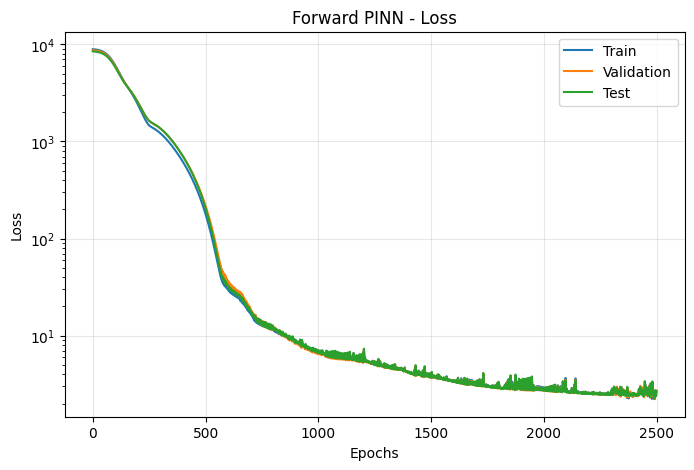

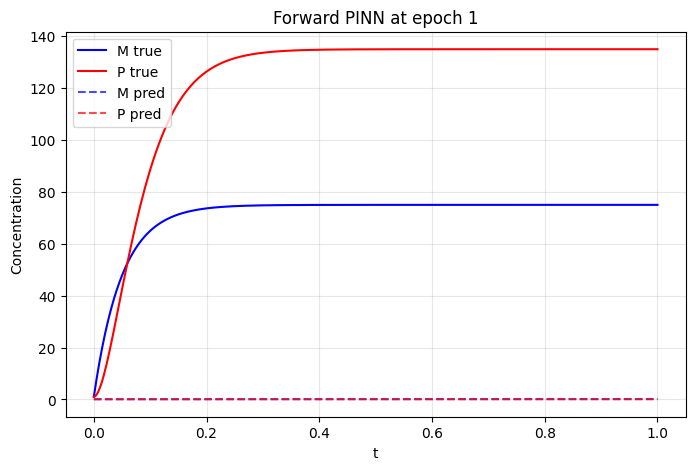

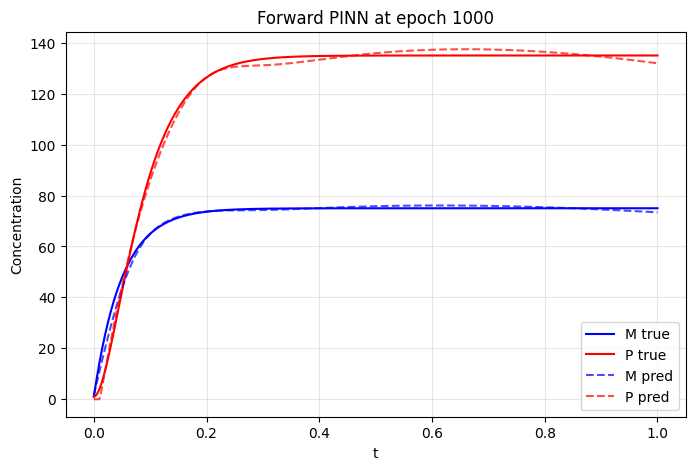

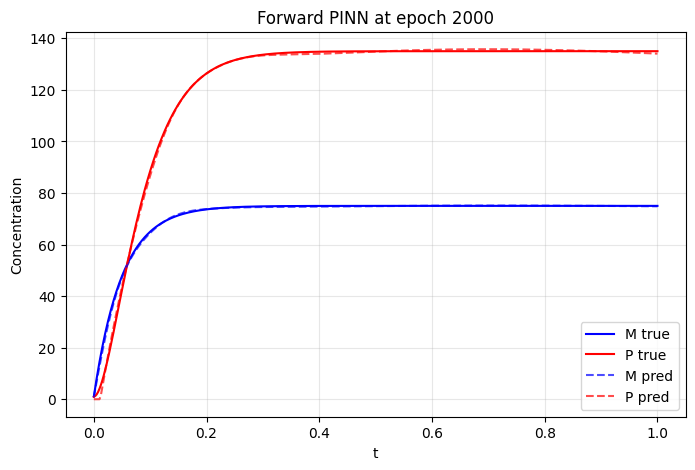

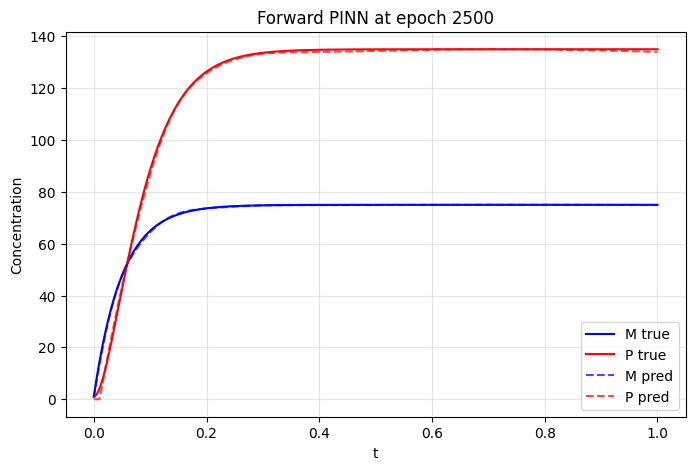

In [40]:
plot_losses_pinn(hist_forward, title="Forward PINN - Loss")
plot_snapshots(hist_forward, t_all_torch, M_true, P_true, title_prefix="Forward PINN")


In [91]:

# -----------------------
# 2) Inverse PINN: learn parameters from data (and solution)
# -----------------------
print("\n=== Training Inverse PINN (parameters learnable) ===")
pinn_inverse = GenePINNBase(hidden_layers=[128,128], learn_params=True).to(device)
optim_inverse = torch.optim.Adam(pinn_inverse.parameters(), lr=1e-3)

pinn_inverse, hist_inverse = train_pinn(pinn_inverse, optim_inverse,
                                       t_train_torch, M_train_torch, P_train_torch,
                                       t_val_torch, M_val_torch, P_val_torch,
                                       t_test_torch, M_test_torch, P_test_torch,
                                       t_all_torch, time_scale,
                                       lambda_data=0.7, lambda_phys=0.3, lambda_ic=1,
                                       max_epochs=10000, print_every=500)

# Evaluate inverse model on full grid
pinn_inverse.eval()
with torch.no_grad():
    M_pred_all_i, P_pred_all_i = pinn_inverse(t_all_torch)
    M_pred_all_i = M_pred_all_i.cpu().numpy().reshape(-1)
    P_pred_all_i = P_pred_all_i.cpu().numpy().reshape(-1)
    km_hat, kp_hat, gm_hat, gp_hat, PN_hat = pinn_inverse.params_phys()
    km_hat = km_hat.item(); kp_hat = kp_hat.item(); gm_hat = gm_hat.item(); gp_hat = gp_hat.item(); PN_hat = PN_hat.item()

print("\nTrue params: ", params_true)
print("Inverse PINN estimated params: ", (km_hat, kp_hat, gm_hat, gp_hat, PN_hat))

# -----------


=== Training Inverse PINN (parameters learnable) ===
Epoch 1/10000 | train=1.465e+04 val=1.428e+04 test=1.388e+04
  data_train=2.092e+04 phys_train=2.614e+01 ic=1.732e+00
  data_val=2.039e+04 phys_val=2.595e+01 ic_val=1.732e+00
  data_test=1.982e+04 phys_test=2.595e+01 ic_test=1.732e+00
  params km=0.5149 kp=0.5149 gm=0.5167 gp=0.5167 PN=9.9990
Epoch 500/10000 | train=3.795e+02 val=4.615e+02 test=4.418e+02
  data_train=5.209e+02 phys_train=1.290e+01 ic=1.097e+01
  data_val=6.381e+02 phys_val=1.293e+01 ic_val=1.097e+01
  data_test=6.099e+02 phys_test=1.293e+01 ic_test=1.097e+01
  params km=0.8500 kp=0.8054 gm=0.1196 gp=0.4449 PN=10.3818
Epoch 1000/10000 | train=8.048e+00 val=8.101e+00 test=8.377e+00
  data_train=6.088e+00 phys_train=9.287e+00 ic=1.000e+00
  data_val=6.255e+00 phys_val=9.073e+00 ic_val=1.000e+00
  data_test=6.650e+00 phys_test=9.073e+00 ic_test=1.000e+00
  params km=1.0509 kp=1.1404 gm=0.1408 gp=0.6361 PN=10.6420
Epoch 1500/10000 | train=5.404e+00 val=5.589e+00 test=5.9

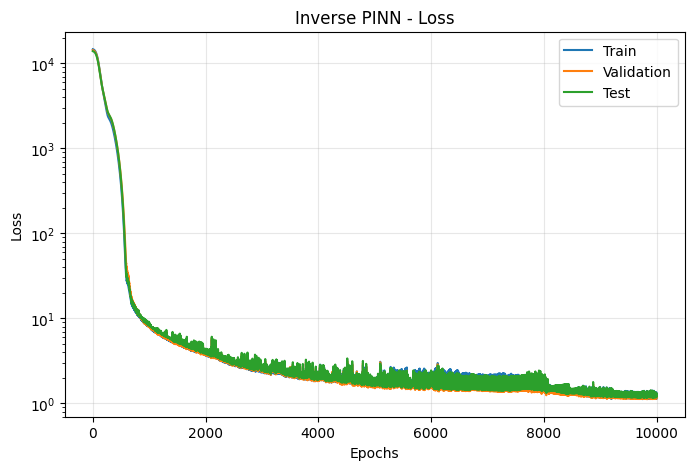

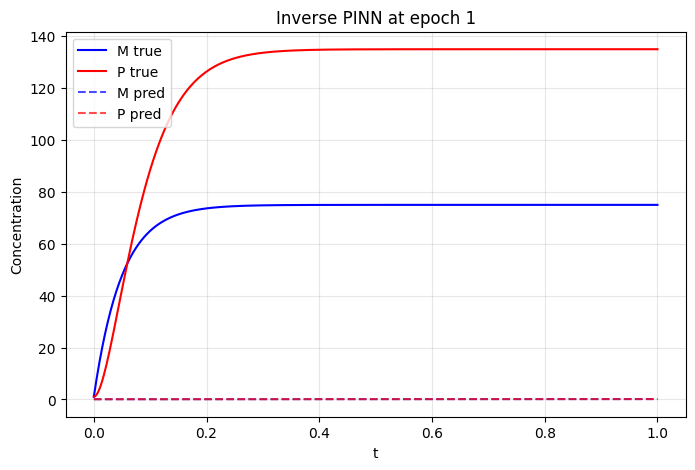

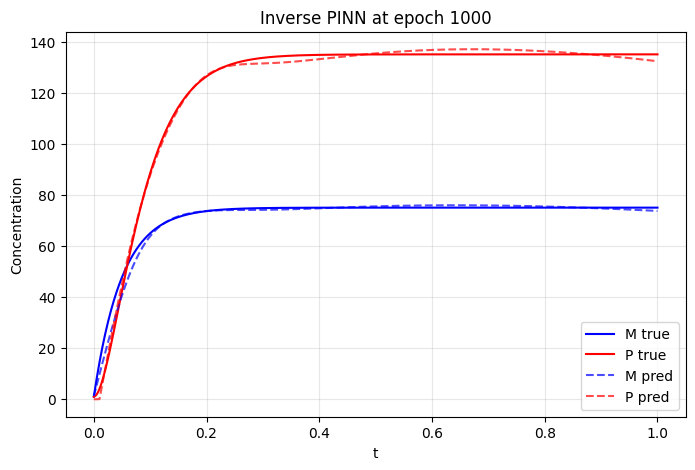

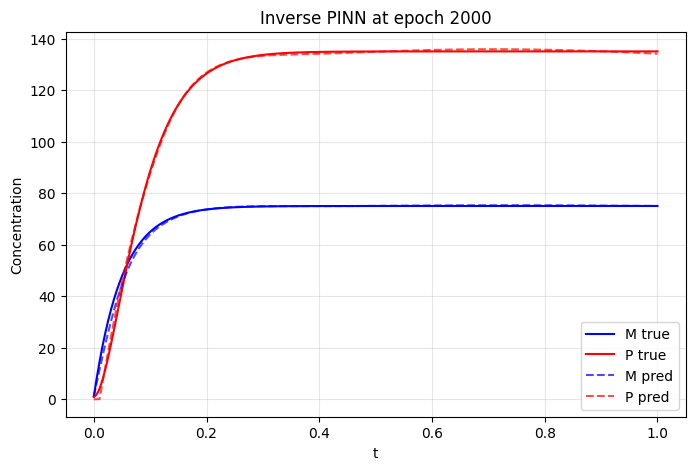

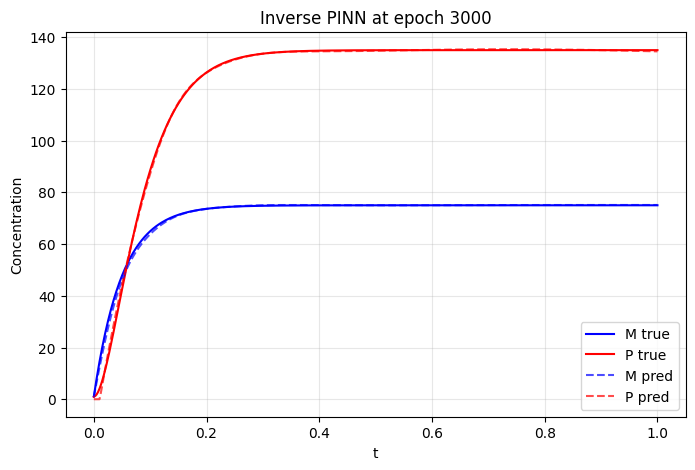

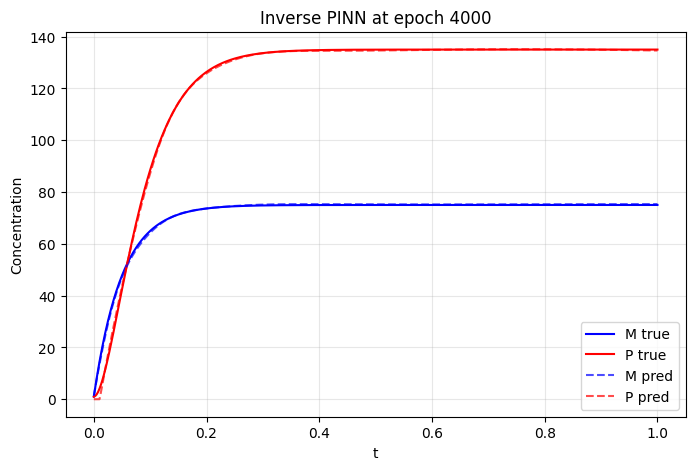

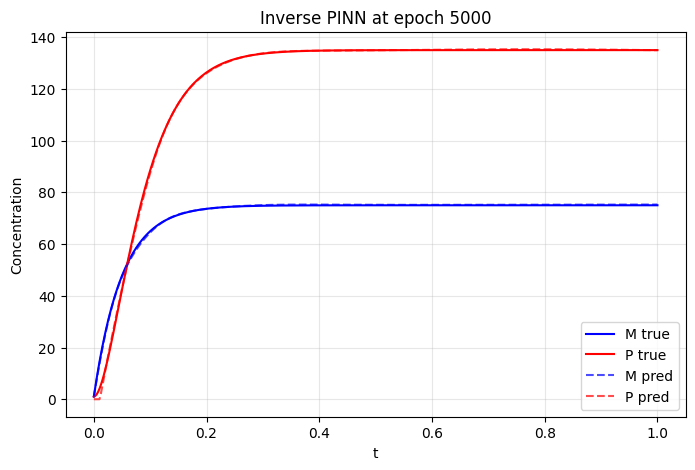

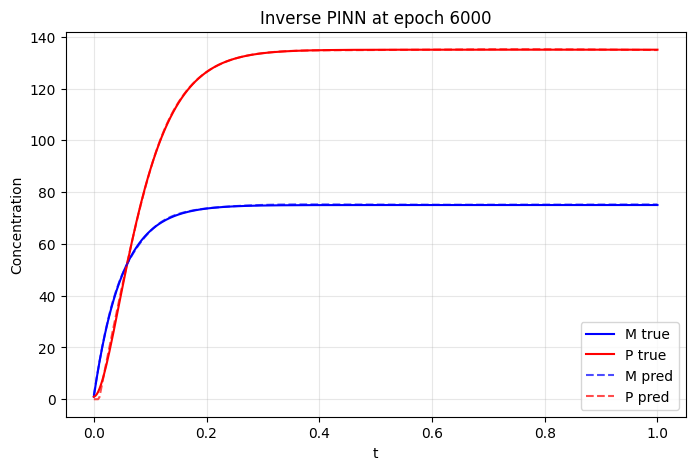

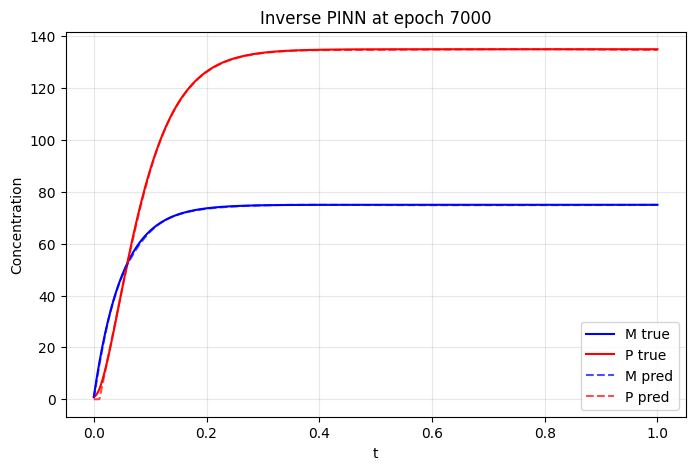

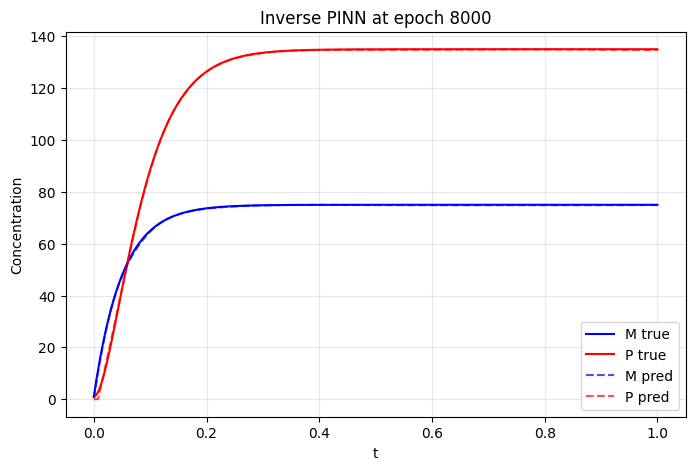

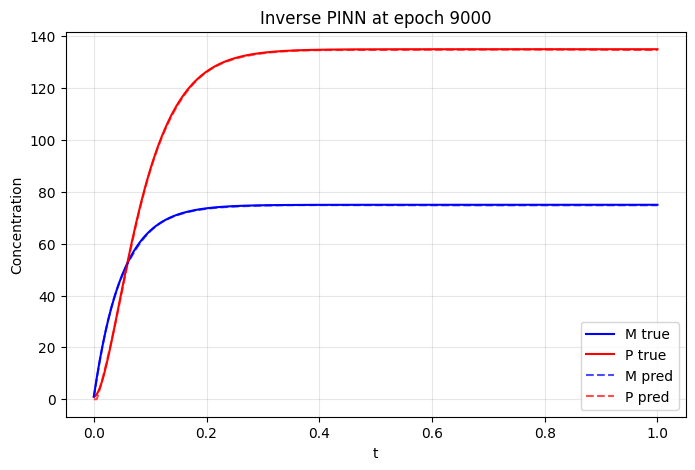

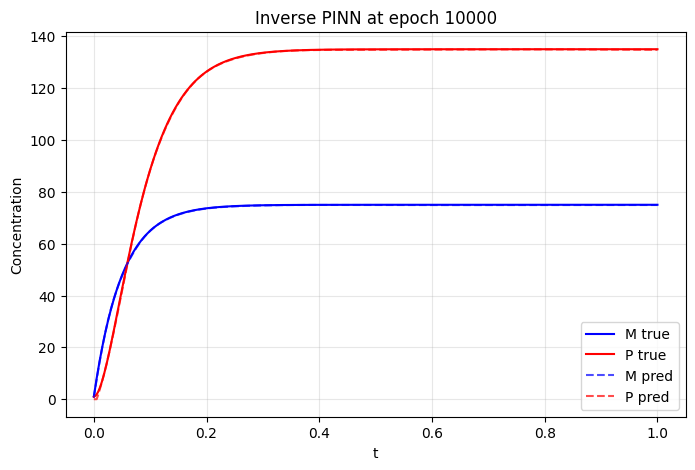

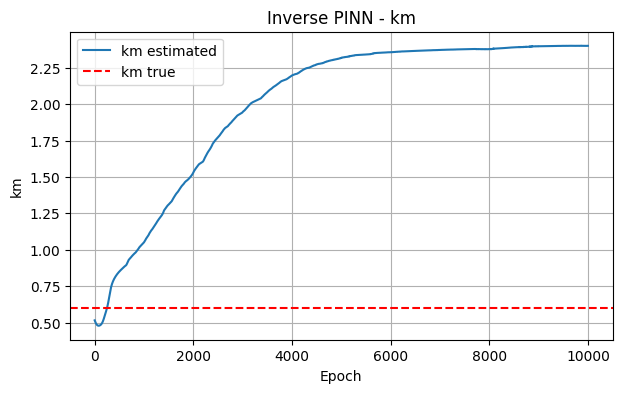

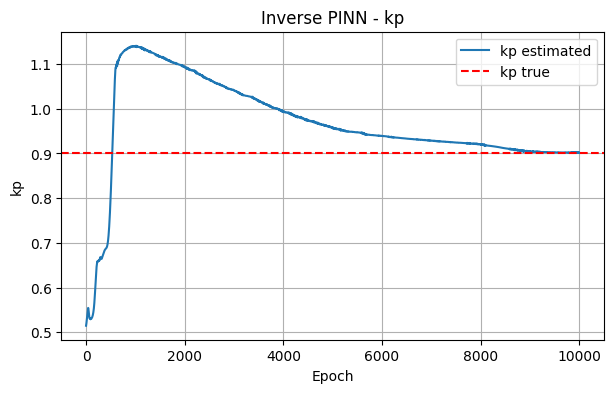

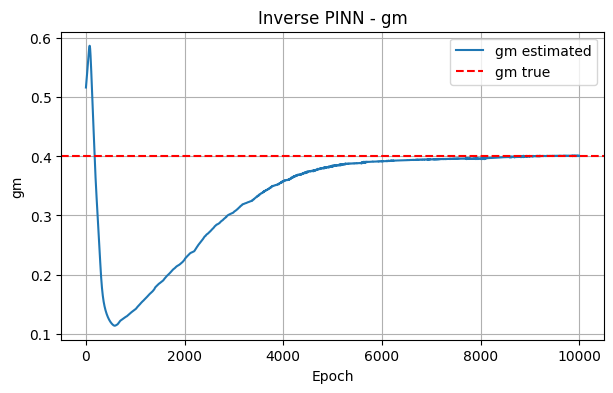

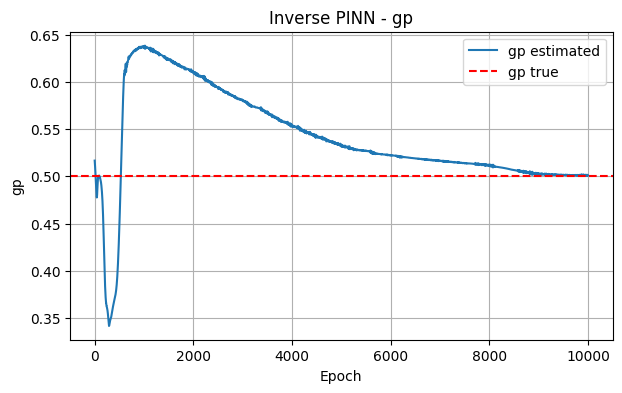

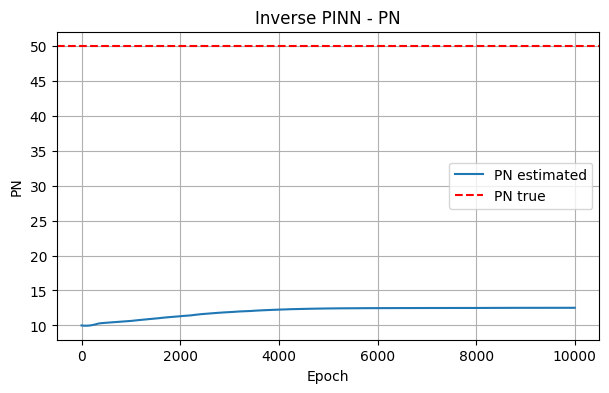

In [92]:
plot_losses_pinn(hist_inverse, title="Inverse PINN - Loss")
plot_snapshots(hist_inverse, t_all_torch, M_true, P_true, title_prefix="Inverse PINN")

plot_params_separate(hist_inverse, params_true={
    "km": params_true[0],
    "kp": params_true[1],
    "gm": params_true[2],
    "gp": params_true[3],
    "PN": params_true[4]
}, title_prefix="Inverse PINN")



In [84]:

# =======================
# Inverse PINN with PN fixed
# =======================
class PINN_PMfixed(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, PN_fixed=50.0):
        super(PINN_PMfixed, self).__init__()
        layers = []
        in_dim = input_dim
        for i, hidden_dim in enumerate(hidden_dims):
            layers.append(nn.Linear(in_dim, hidden_dim))
#            if i % 2 == 0:
#                layers.append(nn.Tanh())
#            else:
#                layers.append(nn.GELU())
            layers.append(nn.GELU())
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, output_dim))
        self.network = nn.Sequential(*layers)

        # Xavier init
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

        # Parametri fisici da apprendere
        self.params = nn.ParameterDict({
            'k_m': nn.Parameter(torch.tensor(0.5, dtype=torch.float32)),
            'gamma_m': nn.Parameter(torch.tensor(0.5, dtype=torch.float32)),
            'k_p': nn.Parameter(torch.tensor(0.5, dtype=torch.float32)),
            'gamma_p': nn.Parameter(torch.tensor(0.5, dtype=torch.float32)),
        })
        self.PN_fixed = PN_fixed

    def forward(self, t):
        return self.network(t)



In [88]:
def train_with_physics_loss_PM(model, optimizer,
                               t_train, M_train, P_train,
                               t_val, M_val, P_val,
                               t_test, M_test, P_test,
                               t_all,
                               M0=None, P0=None,   # IC opzionali
                               epochs=4000, patience=600,
                               save_epochs=[1,1000,2000,3000,4000],
                               lambda_data=0.7, lambda_phys=0.3, lambda_ic=1,
                               time_scale=1.0,
                               print_every=500):
    """
    Training PINN con PN fissato + data loss + physics loss + IC loss.
    History compatibile con le funzioni di plot esistenti.
    """
    mse = nn.MSELoss()
    best_state = None
    best_val = float('inf')
    epochs_no_improve = 0

    history = {
        "loss_train": [], "loss_val": [], "loss_test": [],
        "km": [], "kp": [], "gm": [], "gp": [],
        "snapshots": [], "saved_models": {}
    }

    # spostiamo tensori sul device
    t_train, M_train, P_train = t_train.to(device), M_train.to(device), P_train.to(device)
    t_val, M_val, P_val = t_val.to(device), M_val.to(device), P_val.to(device)
    t_test, M_test, P_test = t_test.to(device), M_test.to(device), P_test.to(device)

    for epoch in range(1, epochs+1):
        model.train()
        optimizer.zero_grad()

        # --- forward train
        out_train = model(t_train)
        M_pred_tr, P_pred_tr = out_train[:,0:1], out_train[:,1:2]

        # --- physics (su t_train con grad abilitato)
        t_phys = t_train.clone().detach().requires_grad_(True)
        out_phys = model(t_phys)
        M_phys, P_phys = out_phys[:,0:1], out_phys[:,1:2]
        dm_dt = torch.autograd.grad(M_phys, t_phys,
                                    grad_outputs=torch.ones_like(M_phys),
                                    create_graph=True)[0] / time_scale
        dp_dt = torch.autograd.grad(P_phys, t_phys,
                                    grad_outputs=torch.ones_like(P_phys),
                                    create_graph=True)[0] / time_scale

        # params
        k_m = model.params['k_m']
        gamma_m = model.params['gamma_m']
        k_p = model.params['k_p']
        gamma_p = model.params['gamma_p']
        PN = model.PN_fixed

        # physics residuals
        phys_m = mse(dm_dt, k_m*PN - gamma_m*M_phys)
        phys_p = mse(dp_dt, k_p*M_phys - gamma_p*P_phys)
        phys_loss = phys_m + phys_p

        # data loss
        data_loss = mse(M_pred_tr, M_train) + mse(P_pred_tr, P_train)

        # IC loss
        ic_loss = torch.tensor(0.0, device=device)
        if M0 is not None and P0 is not None:
            out0 = model(torch.zeros((1,1), dtype=torch.float32, device=device))
            M0_pred, P0_pred = out0[:,0:1], out0[:,1:2]
            ic_loss = mse(M0_pred, torch.tensor([[M0]], dtype=torch.float32,device=device)) + \
                      mse(P0_pred, torch.tensor([[P0]],dtype=torch.float32, device=device))

        # total
        loss = lambda_data*data_loss + lambda_phys*phys_loss + lambda_ic*ic_loss
        loss.backward()
        optimizer.step()

        # --- validation
        with torch.enable_grad():
            out_val = model(t_val)
            M_pred_val, P_pred_val = out_val[:,0:1], out_val[:,1:2]

            t_phys_val = t_val.clone().detach().requires_grad_(True)
            out_phys_val = model(t_phys_val)
            M_phys_val, P_phys_val = out_phys_val[:,0:1], out_phys_val[:,1:2]
            dm_dt_val = torch.autograd.grad(M_phys_val, t_phys_val,
                                            grad_outputs=torch.ones_like(M_phys_val),
                                            create_graph=True)[0] / time_scale
            dp_dt_val = torch.autograd.grad(P_phys_val, t_phys_val,
                                            grad_outputs=torch.ones_like(P_phys_val),
                                            create_graph=True)[0] / time_scale

            phys_val = mse(dm_dt_val, k_m*PN - gamma_m*M_phys_val) + \
                       mse(dp_dt_val, k_p*M_phys_val - gamma_p*P_phys_val)
            data_val = mse(M_pred_val, M_val) + mse(P_pred_val, P_val)
            val_loss = lambda_data*data_val + lambda_phys*phys_val

        # --- test (solo monitoraggio: data loss)
        with torch.no_grad():
            out_test = model(t_test)
            M_pred_ts, P_pred_ts = out_test[:,0:1], out_test[:,1:2]
            test_loss = mse(M_pred_ts, M_test) + mse(P_pred_ts, P_test)

        # log
        history["loss_train"].append(loss.item())
        history["loss_val"].append(val_loss.item())
        history["loss_test"].append(test_loss.item())
        history["km"].append(k_m.item())
        history["kp"].append(k_p.item())
        history["gm"].append(gamma_m.item())
        history["gp"].append(gamma_p.item())

        # early stopping
        if val_loss.item() < best_val:
            best_val = val_loss.item()
            best_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        # snapshots
        if epoch in save_epochs:
            model.eval()
            with torch.no_grad():
                out_all = model(t_all)
                M_all, P_all = out_all[:,0:1], out_all[:,1:2]
            history["snapshots"].append({
                "epoch": epoch,
                "M": M_all.cpu().numpy().reshape(-1),
                "P": P_all.cpu().numpy().reshape(-1)
            })
            history["saved_models"][epoch] = copy.deepcopy(model.state_dict())

        # print progress
        if epoch % print_every == 0 or epoch == 1:
            print(f"[PMfixed] Epoch {epoch} | Train {loss.item():.3e} | Val {val_loss.item():.3e} | Test {test_loss.item():.3e}")
            print(f"  km={k_m.item():.3f}, kp={k_p.item():.3f}, gm={gamma_m.item():.3f}, gp={gamma_p.item():.3f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history


In [89]:
params_true = (0.6, 0.9, 0.4, 0.5, 50.0)

# modello con PN fisso = 50.0
pinn_pm = PINN_PMfixed(input_dim=1, hidden_dims=[128,128], output_dim=2, PN_fixed=params_true[4]).to(device)
optim_pm = torch.optim.Adam(pinn_pm.parameters(), lr=1e-3)

pinn_pm, hist_pm = train_with_physics_loss_PM(
    pinn_pm, optim_pm,
    t_train_torch, M_train_torch, P_train_torch,
    t_val_torch, M_val_torch, P_val_torch,
    t_test_torch, M_test_torch, P_test_torch,
    t_all_torch,
    M0=M_true[0], P0=P_true[0],   # IC
    epochs=10000, patience=600,
    save_epochs=[1,5000,7500,10000],
    time_scale=time_scale
)

[PMfixed] Epoch 1 | Train 1.485e+04 | Val 1.447e+04 | Test 1.984e+04
  km=0.499, kp=0.499, gm=0.501, gp=0.501
[PMfixed] Epoch 500 | Train 1.238e+03 | Val 1.356e+03 | Test 1.909e+03
  km=0.443, kp=0.659, gm=0.295, gp=0.350
[PMfixed] Epoch 1000 | Train 6.712e+01 | Val 8.959e+01 | Test 9.606e+01
  km=0.379, kp=0.881, gm=0.247, gp=0.489
[PMfixed] Epoch 1500 | Train 1.766e+01 | Val 1.951e+01 | Test 2.065e+01
  km=0.366, kp=1.459, gm=0.240, gp=0.818
[PMfixed] Epoch 2000 | Train 1.323e+01 | Val 1.234e+01 | Test 1.430e+01
  km=0.368, kp=1.531, gm=0.241, gp=0.860
[PMfixed] Epoch 2500 | Train 1.086e+01 | Val 9.072e+00 | Test 1.102e+01
  km=0.380, kp=1.337, gm=0.249, gp=0.749
[PMfixed] Epoch 3000 | Train 8.960e+00 | Val 6.607e+00 | Test 8.493e+00
  km=0.399, kp=1.156, gm=0.262, gp=0.646
[PMfixed] Epoch 3500 | Train 7.411e+00 | Val 4.906e+00 | Test 6.521e+00
  km=0.425, kp=1.059, gm=0.280, gp=0.591
[PMfixed] Epoch 4000 | Train 6.062e+00 | Val 3.610e+00 | Test 4.894e+00
  km=0.455, kp=1.008, gm=0.3

In [77]:
def plot_params_pm_fixed(history, params_true=None, title_prefix="PM fixed"):
    """
    Plotta i parametri stimati (km, kp, gm, gp) nel caso di PINN con PN fissato.
    
    Args:
        history: dict restituito da train_with_physics_loss_PM
        params_true: dict con i valori veri dei parametri, es. {"km":0.6,"kp":0.9,"gm":0.4,"gp":0.5}
        title_prefix: titolo da anteporre a ciascun plot
    """
    for key in ["km","kp","gm","gp"]:
        if key in history:  # controllo per evitare KeyError
            plt.figure(figsize=(7,4))
            plt.plot(history[key], label=f"{key} estimated")
            if params_true is not None and key in params_true:
                plt.axhline(params_true[key], linestyle="--", color="red", label=f"{key} true")
            plt.xlabel("Epochs")
            plt.ylabel("Value")
            plt.title(f"{title_prefix}: {key}")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()


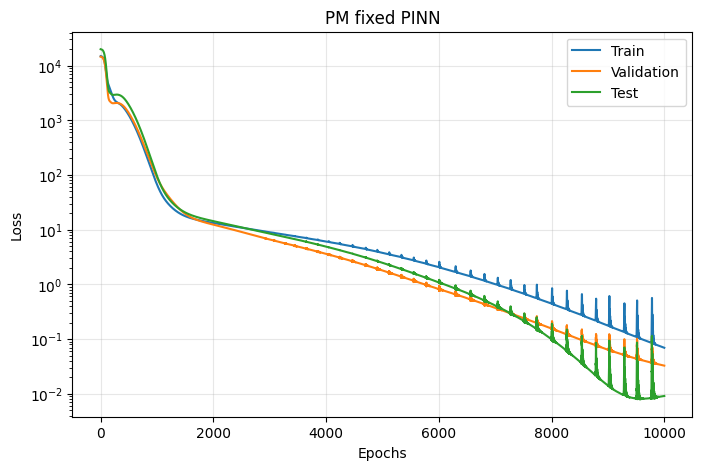

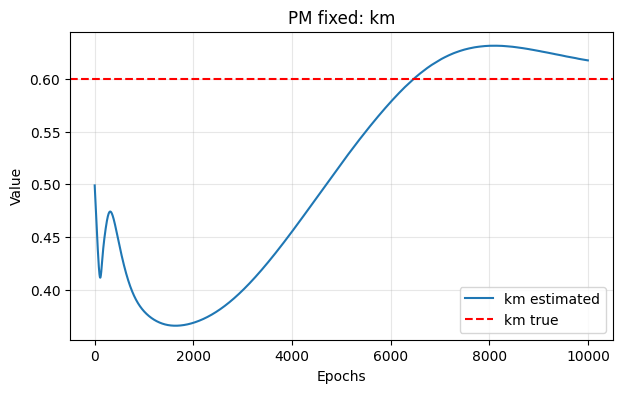

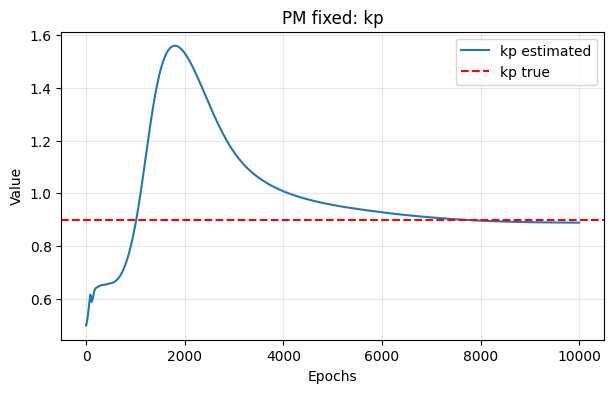

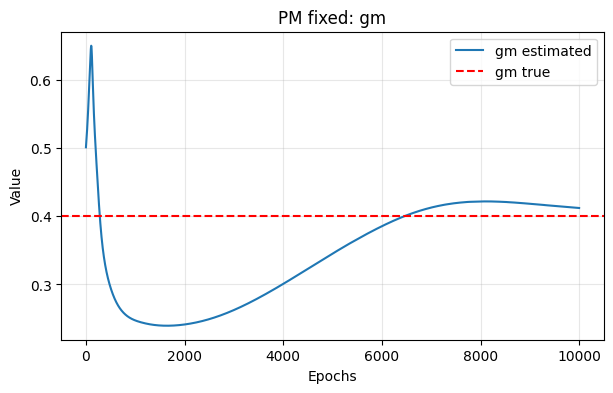

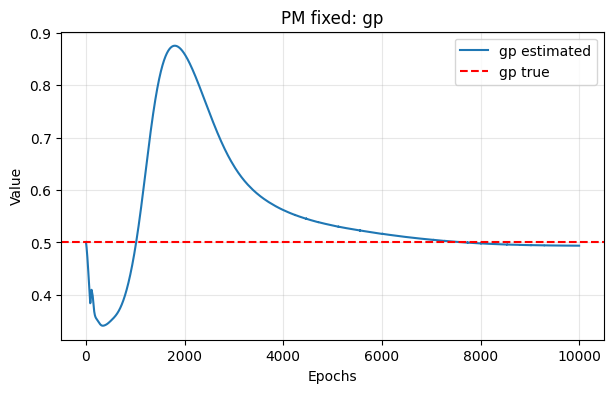

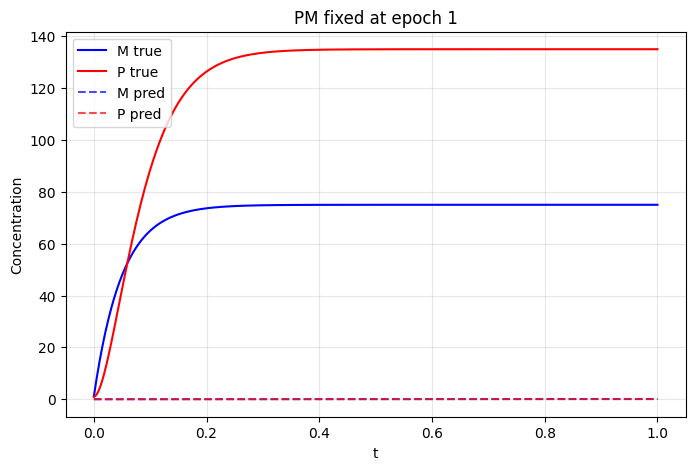

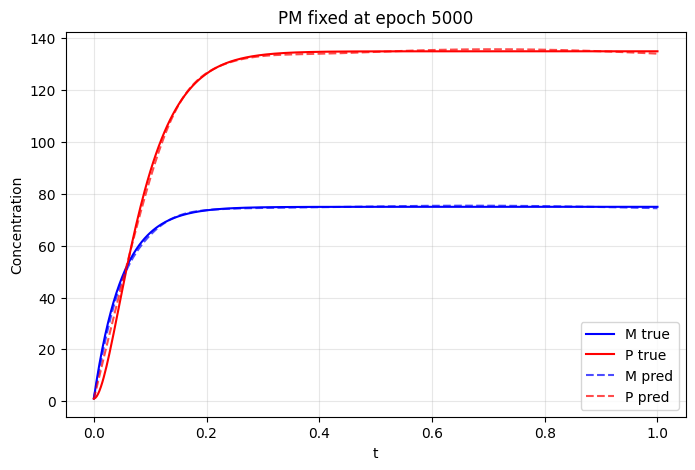

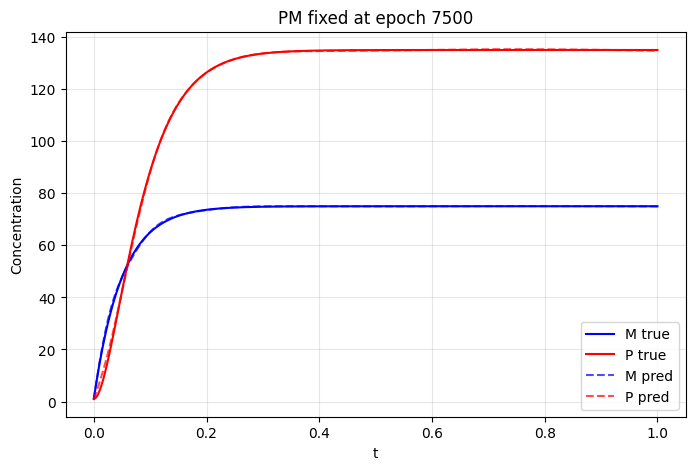

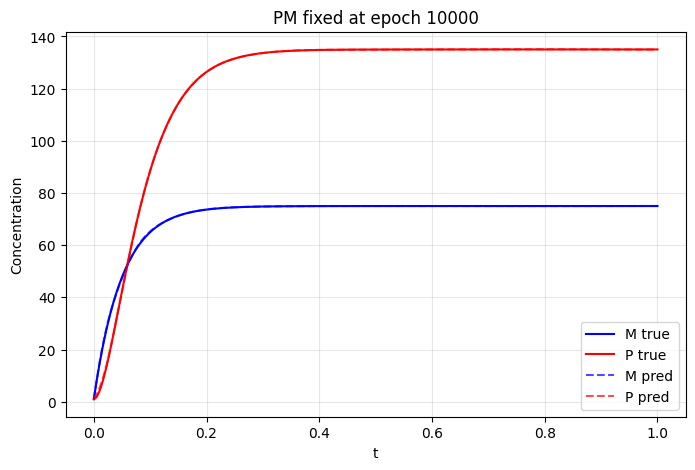

In [90]:
plot_losses_pinn(hist_pm, title="PM fixed PINN")
plot_params_pm_fixed(
    hist_pm,
    params_true={"km":0.6,"kp":0.9,"gm":0.4,"gp":0.5},
    title_prefix="PM fixed"
)
plot_snapshots(hist_pm, t_all_torch, M_true, P_true, title_prefix="PM fixed")
